# 2. Spectral Clustering

Here I'll implement spectral clustering of the Hamming distance matrix by building a graph.

Since the Hamming distance is pairwise, the matrix needs to be 'mapped' to a coordinate system prior to clustering.

Steps:

1. Distance metric used is the Hamming distance, which is used to determine the distance between sequence strings.
2. Build a k-nearest neighbors adjacency matrix $A$ using the Hamming matrix.
3. Will build a graph Laplacian matrix $L$ based on Adjacency matrix $A$ and Degree matrix $D$
4. Find eigenpairs (spectum) and select $k$ smallest
5. Use $k$-means to fit $k$ clusters to the selected $k$ eigenvectors.

---


Import Packages


In [1]:
import sys


sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np


from numba import jit


from sklearn import neighbors


from scipy import sparse


from utils.utils import elbow_diagram, run_kmeans

Load data


In [2]:
trim_seqs = np.load("../data/trim_seqs.npy")

Calculate Hamming Distance for all pairs.


In [3]:
@jit(nopython=True)
def get_hamming_distance(seqs, base_id=0):
    model_org = seqs[base_id]
    ham_mask = np.not_equal(seqs, model_org)
    return np.sum(ham_mask, axis=1)


@jit(nopython=True)
def get_hamming_matrix(seqs):
    l = len(seqs)
    Dh = np.zeros((l, l), dtype="int16")
    for i in range(l):
        Dh[:, i] = get_hamming_distance(seqs, i)
    return Dh

Assign Hamming Distance to Adjacency Matrix $A$


In [4]:
A = get_hamming_matrix(trim_seqs)
A[:10, :10]

array([[ 0,  0, 44,  1, 18, 45, 44, 53,  2, 44],
       [ 0,  0, 44,  1, 18, 45, 44, 53,  2, 44],
       [44, 44,  0, 43, 32,  3, 34, 39, 42, 34],
       [ 1,  1, 43,  0, 17, 44, 43, 52,  1, 43],
       [18, 18, 32, 17,  0, 33, 28, 37, 16, 28],
       [45, 45,  3, 44, 33,  0, 35, 40, 43, 35],
       [44, 44, 34, 43, 28, 35,  0, 37, 42,  0],
       [53, 53, 39, 52, 37, 40, 37,  0, 51, 37],
       [ 2,  2, 42,  1, 16, 43, 42, 51,  0, 42],
       [44, 44, 34, 43, 28, 35,  0, 37, 42,  0]], dtype=int16)

Display adjacency matrix as an image.

Note: no gross patterns as were observed _after_ cleaning data.


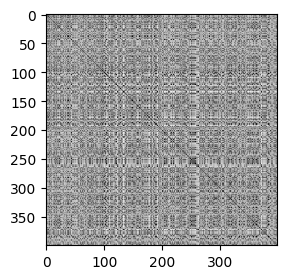

In [5]:
plt.figure(figsize=(3, 3))
plt.tight_layout()
plt.imshow(A, cmap="gray")
plt.savefig(rf"../plots/adj_unsorted.png")
plt.show()

Plot histogram of _maximum_ distances across sequences


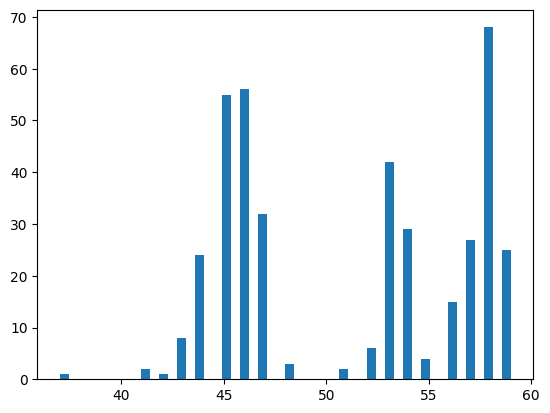

In [6]:
A_max = np.max(A, axis=0)
_ = plt.hist(A_max, bins=50)

Plot histogram of _mean_ distances across sequences

A potential niave method would be to cluster the mean distances. However, this may be problematic for network adjacency data.


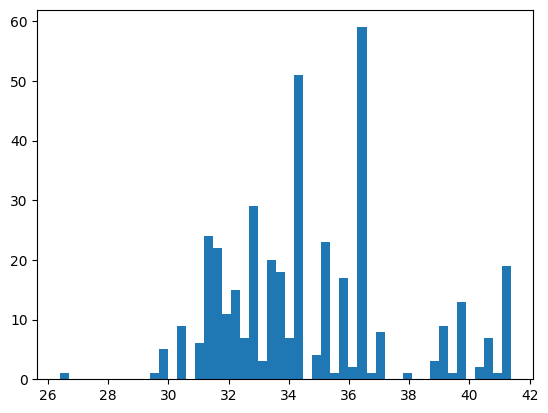

In [7]:
A_mean = np.mean(A, axis=0)
_ = plt.hist(A_mean, bins=50)

Plot histogram of _standard deviation_ of distances across sequences


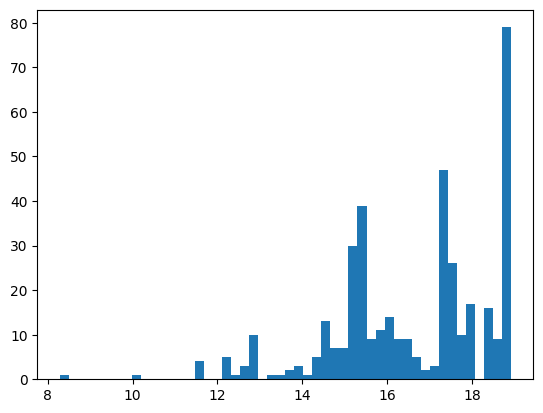

In [8]:
A_std = np.std(A, axis=0)
_ = plt.hist(A_std, bins=50)

To improve performance of the clustering, reduce connections in graph to only incluide the $k$ nearest neighbors

Convert sparse matrix (CSC) to dense np.ndarray.


In [9]:
k_nn = 75
knn_distance = neighbors.kneighbors_graph(
    A, n_neighbors=k_nn, include_self=False, mode="distance"
)
A_nn = np.asarray(sparse.csc_matrix.todense(knn_distance))
A_nn[:5, :5]

array([[  0.        ,   0.        ,   0.        ,  20.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,  20.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [ 20.        ,  20.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        , 297.88756268,   0.        , 281.84215441,
          0.        ]])

Calculate Degree matrix $D$

Alternatively, tried $D^{-\frac{1}{2}}$


In [10]:
d = np.sum(A_nn, axis=1)
D = np.diag(d)
D[:5, :5]
# D_inv_root = np.diag(1/np.sqrt(d))
# D_inv_root[:5,:5]

array([[ 5901.38248364,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,  5901.38248364,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,  2147.30754424,     0.        ,
            0.        ],
       [    0.        ,     0.        ,     0.        ,  5300.04717951,
            0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
        15994.27446774]])

Calculate the Graph Laplacian matrix $L$

Note: The $L = D - A$ method gives the best results. The $L = D^{-\frac{1}{2}} \cdot A \cdot D^{-\frac{1}{2}}$ method didn't perform as well.


In [11]:
# L = D_inv_root @ A3 @ D_inv_root
L = D - A_nn
L[:5, :5]

array([[ 5901.38248364,     0.        ,     0.        ,   -20.        ,
            0.        ],
       [    0.        ,  5901.38248364,     0.        ,   -20.        ,
            0.        ],
       [    0.        ,     0.        ,  2147.30754424,     0.        ,
            0.        ],
       [  -20.        ,   -20.        ,     0.        ,  5300.04717951,
            0.        ],
       [    0.        ,  -297.88756268,     0.        ,  -281.84215441,
        15994.27446774]])

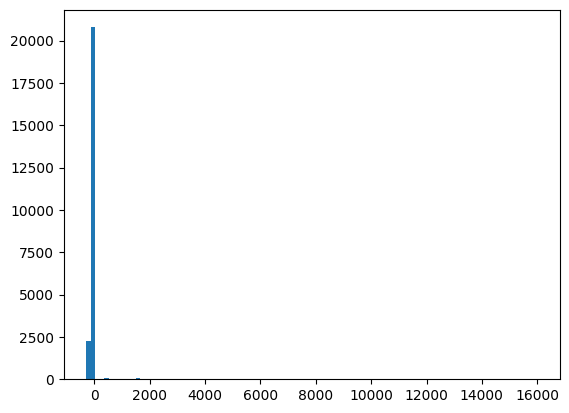

In [12]:
L2 = L.flatten()
L2 = L2[L2 != 0]
plt.hist(L2, bins=100)
plt.show()

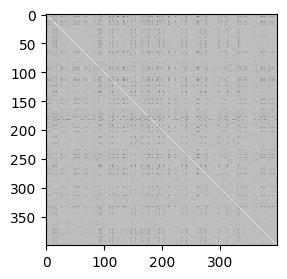

In [13]:
plt.figure(figsize=(3, 3))
plt.tight_layout()
plt.imshow(np.minimum(L, 100), cmap="gray")
plt.savefig(rf"../plots/laplace_unsorted.png")
plt.show()

Get eigenpairs.


In [14]:
v, x = np.linalg.eig(L)
v = v.real
v_sort = np.sort(np.abs(v))
v_sort[:8]

array([7.97927508e-13, 1.75169139e-12, 2.54206797e-12, 4.26894987e-12,
       1.04777581e+00, 3.96493239e+02, 3.96493239e+02, 3.96493239e+02])

Sort eigenvectors in ascending order based on eigenvalues.


In [15]:
x = x.real
idx = np.argsort(np.abs(v))  # the index of eigenvalue sorted acsending
x_sort = x[:, idx]  # select the k largest eigenvectors
x_sort[:5, :5]

array([[-1.06473442e-02,  5.62282371e-02,  7.82371374e-04,
        -2.92172742e-02, -1.11883335e-01],
       [-1.06473442e-02,  5.62282371e-02,  7.82371374e-04,
        -2.92172742e-02, -1.11883335e-01],
       [-9.45143089e-03, -1.78054399e-02, -2.38928775e-03,
        -1.07521235e-01, -2.03953816e-15],
       [-1.06473442e-02,  5.62282371e-02,  7.82371374e-04,
        -2.92172742e-02, -1.11884562e-01],
       [-1.06473442e-02,  5.62282371e-02,  7.82371374e-04,
        -2.92172742e-02, -1.05779166e-01]])

Function to visualize eigenvectors.


In [16]:
def plot_eigs(i, j, v, labels=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.scatter((v[:, i]), (v[:, j]), c=labels)

    ax.set_xlabel(f"Eigenvector {i}")
    ax.set_ylabel(f"Eigenvector {j}")
    # ax.set_title(f"Eigenvectors {i} & {j}")
    plt.show()

Look at a few combinations of eignvectors.


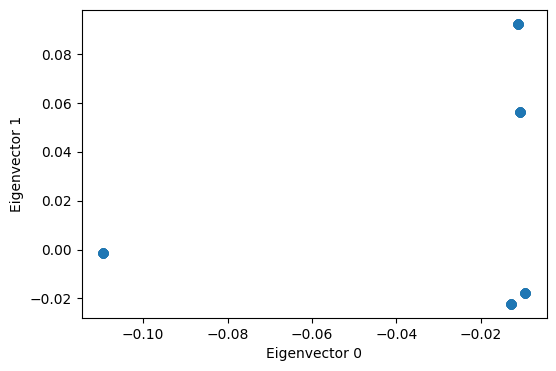

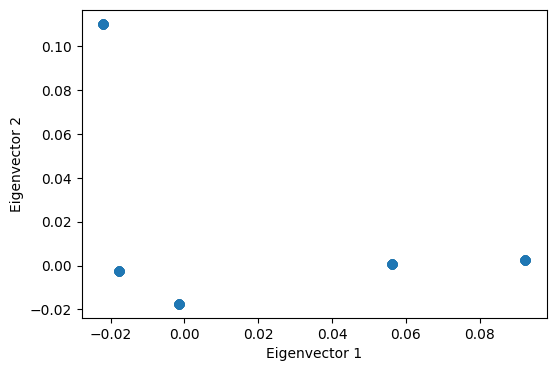

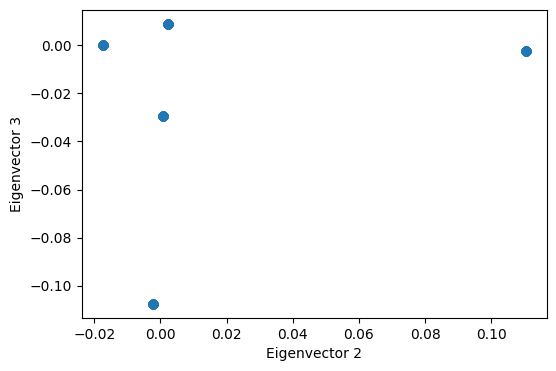

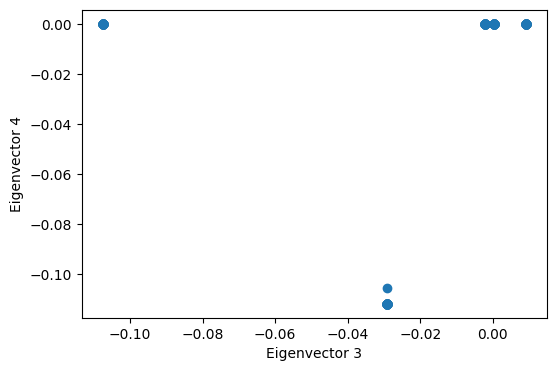

In [17]:
for i, j in zip(range(0, 4, 1), range(1, 5, 1)):
    plot_eigs(i, j, x_sort)

Execute $k$-means over a range of $k$ values and plot _Elbow Diagram_.


In [18]:
k_min = 1  # 0-index
k_max = 10
n_dim = 5
norm_inertia = [
    run_kmeans(k, x_sort, n_dim, n_init=25).inertia_ for k in range(k_min, k_max)
]
ct = [*range(k_min, k_max)]

c:\Users\Josh.Meehl\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Josh.Meehl\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


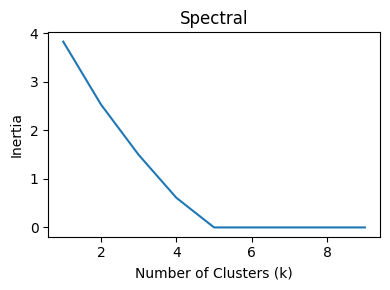

In [19]:
elbow_diagram(
    norm_inertia,
    ct,
    log=False,
    filename="../plots/elbow_spectral.png",
    title="Spectral",
)

It appears that there $k=5$ is the best fit on the elbow diagrams.

---

## Model Validation

Get labels for $k$


In [20]:
k = 9
km = run_kmeans(k, x_sort, n_dim, n_init=25)
label = km.labels_

Spot check some labels vs Hamming distances as a sanity check.


In [21]:
n = 25
print(np.stack([label[:n], A[:n, 0]]))

[[ 6  6  3  6  5  3  4  0  6  4  2  6  3  1  4  3  2  7  4  2  3  3  2  2
   3]
 [ 0  0 44  1 18 45 44 53  2 44 58  0 47 15 45 45 58 15 43 59 47 46 57 58
  46]]


Look at frequency of occurance for each cluster


In [22]:
unique, frequency = np.unique(label, return_counts=True)
print(unique, frequency)

[0 1 2 3 4 5 6 7 8] [80 13 80 80 80  1 58  7  1]


Note that the above shows a cluster with only 1 data point, indicating this 'cluster' is an outlier on the spectral data.


Visualize


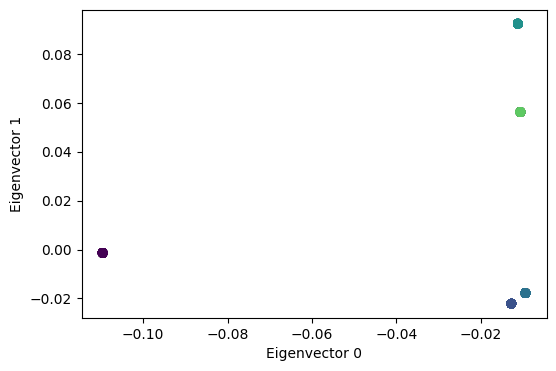

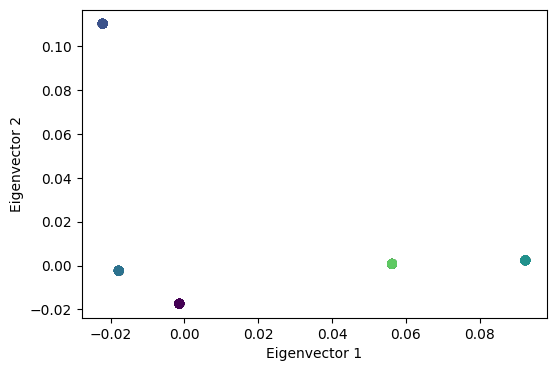

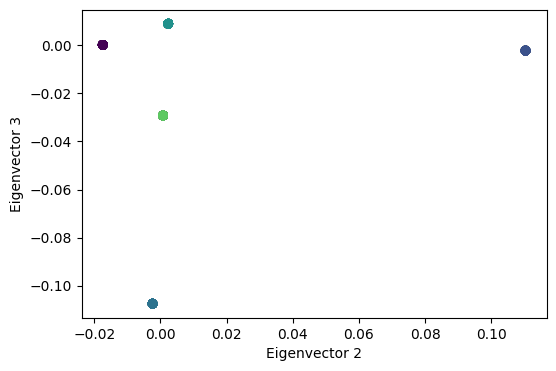

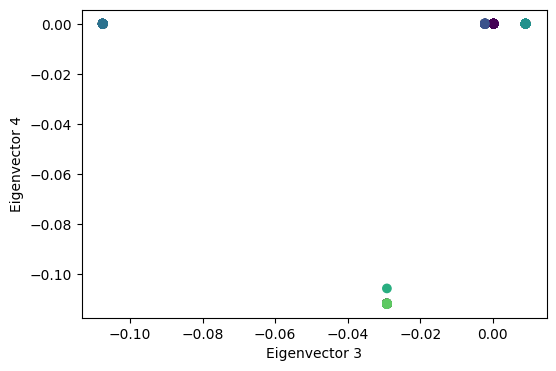

In [23]:
for i, j in zip(range(0, 4, 1), range(1, 5, 1)):
    plot_eigs(i, j, x_sort, labels=label)

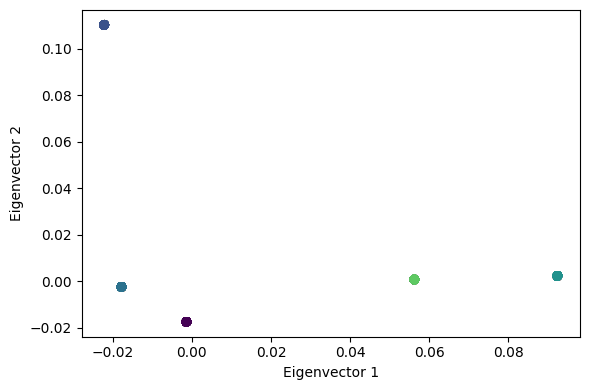

In [24]:
i, j = (1, 2)
v = x_sort
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter((v[:, i]), (v[:, j]), c=label)

ax.set_xlabel(f"Eigenvector {i}")
ax.set_ylabel(f"Eigenvector {j}")
# ax.set_title(f"Eigenvectors {i} & {j}")
plt.tight_layout()
plt.savefig(rf"../plots/spectral_eigs_{i}_{j}.png")
plt.show()

Visualize sequence clusters


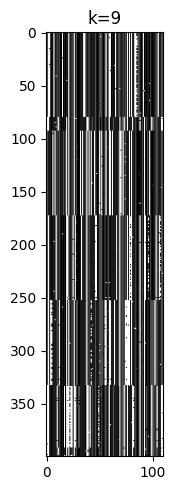

In [25]:
sort_seqs = trim_seqs[label.argsort(), :]

plt.figure(figsize=(2, 5))
plt.title(f"k={k}")
plt.imshow(sort_seqs, cmap="gray")
plt.tight_layout()
plt.savefig(rf"../plots/sequences_sorted_{k}.png")
plt.show()

Visualize Adjacency Matrix


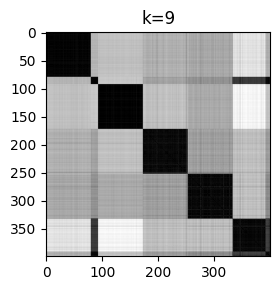

In [26]:
A_sort = A[label.argsort(), :][:, label.argsort()]

plt.figure(figsize=(3, 3))
plt.title(f"k={k}")
plt.tight_layout()
plt.imshow(A_sort, cmap="gray")
plt.savefig(rf"../plots/adj_sorted_{k}.png")
plt.show()

Save data


In [27]:
save_path = "../data/x_sort.npy"
np.save(save_path, x_sort)

save_path = "../data/A.npy"
np.save(save_path, A)

---

## Conclusion

Based on reviewing the elbow diagram and eigenvector plots, there appears to be 5 main clusters.

Also, the Graph Laplacian had 4 eigenvalues near-zero and a 5th that is also very small. indicating 4-5 distinct graphs.

Sorting the sequence by cluster labels shows that the data does look better with 5 clusters versus 4. This may indicate the amount of relatedness between strains, with 4 main variants, and one variant having 2 distinct sub-variants.

However, I would caution in using the results prior to validation, since 3 hyper-parameters had to be tuned:

- $k_{nn}$ for number of neighbors to connect in graph
- $n_{eig}$ for number of eigenvectors to cluster
- $k$ for number of clusters.

This analysis should be evaluated against some known experimental data prior to accepting it as valid means of representing a Hamming distance matrix for genomic sequences.

Also visualizing the adjacency graph directly in a package such as `networkx` would help validate the method.

In practice, since genomic sequencing is a domain I am unfamiliar with, I would review the problem with knowledgeable domain experts (e.g. bioinformatic scientists) and do a review of the literature prior to implementing a method.
